In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Display the row's columns and data in dictionary format
Measurement_example_row = session.query(Measurement).first()
Measurement_example_row.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fede51055e0>,
 'id': 1,
 'date': '2010-01-01',
 'prcp': 0.08,
 'tobs': 65.0,
 'station': 'USC00519397'}

In [10]:
# Display the row's columns and data in dictionary format
Station_example_row = session.query(Station).first()
Station_example_row.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fede510e070>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

In [11]:
# Find the most recent date in the data set.
latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest = latest[0] # Prepping for conversion to datetime from string
latest


'2017-08-23'

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set using timedelta.
dt_latest = pd.to_datetime(latest, format="%Y-%m-%d")
dt_year = dt_latest - timedelta(days=365)
dt_year = dt_year.strftime("%Y-%m-%d")

# Perform a query to retrieve the data and precipitation scores
# (Sort the dataframe by date -- NOTE: this is done already in the query)
percipitation_query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= dt_year).\
    order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(percipitation_query, columns=['Date', 'Precipitation'])
df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d")
df.set_index('Date', inplace=True)


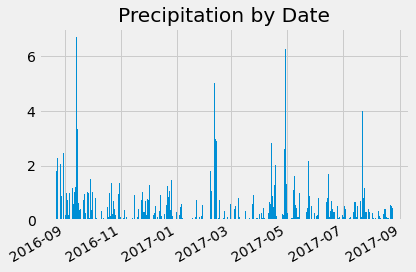

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
# Attempting a new approach using datetime elements directly: https://stackoverflow.com/questions/13515471/matplotlib-how-to-prevent-x-axis-labels-from-overlapping-each-other
fig, ax = plt.subplots()

# Make a bar plot
ax.bar(df.index, df['Precipitation'], align='center')

# Tell matplotlib to interpret the x-axis values as dates
ax.xaxis_date()

# Make space for and rotate the x-axis tick labels and then format
fig.autofmt_xdate()
plt.title('Precipitation by Date')
plt.tight_layout()
plt.show()


In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset 
station_query1 = session.query(Station.station, func.count('*')).\
    group_by(Station.station).all()
len(station_query1)                        


9

In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_query2 = session.query(Measurement.station, func.count('*')).\
    group_by(Measurement.station).\
    order_by(func.count('*').desc()).all()  
most_active_station = station_query2[0][0]
station_query2


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_max = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station).first()
station_min = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station).first()
station_avg = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).first()


In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Find the most recent date in the data set.
station_date = session.query(Measurement.date).filter(Measurement.station == most_active_station).order_by(Measurement.date.desc()).first()

# Calculate the date one year from the last date in station's data set.
station_date = pd.to_datetime(station_date, format="%Y-%m-%d")
station_year = station_date - timedelta(days=365)
station_year = station_year.strftime("%Y-%m-%d")

# Perform a query to retrieve the tobs 
temperature_query = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= dt_year).\
    filter(Measurement.station == most_active_station).\
    order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df2 = pd.DataFrame(temperature_query, columns=['Date', 'Temperature'])
df2['Date'] = pd.to_datetime(df2['Date'], format="%Y-%m-%d")
df2.set_index('Date', inplace=True)
df2



,Temperature
Date,
2017-08-18,79.0
2017-08-17,76.0
2017-08-16,76.0
2017-08-15,77.0
2017-08-14,77.0
...,...
2016-08-27,75.0
2016-08-26,80.0
2016-08-25,80.0


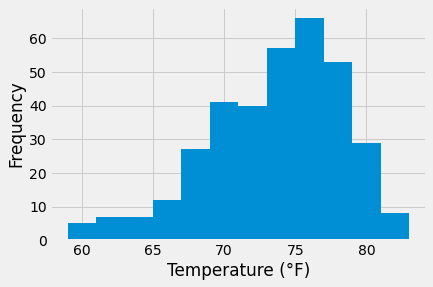

In [19]:
# Plot the histogram 
plt.hist(df2['Temperature'], bins=12)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.show()


# Close session

In [20]:
# Close Session
session.close()